
<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/ai/ai-2-uis-student/-/raw/master/imgs/Banner_IA2_1.png" style="width:1500px;heigth:100px">

# **1. Propose a RNN to predict new COVID infected and deads in Colombia**

Current COVID-19 report in Colombia is available [here](https://www.datos.gov.co/Salud-y-Protecci-n-Social/Casos-positivos-de-COVID-19-en-Colombia/gt2j-8ykr/data). Taken from (www.datos.gov.co). You should estimated **the daily cases** of:
-  new deads (muertes) for next **100** days. 

Please,take into account, the next instructions: 

1. For prediction variables  ( new deads (muertes)) split on training (70) and test (30%).
2. As training features (**X**) use the previously N-values of each variable. Evaluate the algorithm with $N=\{7\} $. 
3. Use also a single (use temporal window as features) and  multivariate approach (use almost other three features from report). 
4. Evaluate the algorithm with curren data, to measure the error, and then you should obtain new 100 points, corresponding to next **100** days. 



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## RNN Single


Se cargan los datos correspondientes únicamente a las muertes por día.


In [ ]:
df = pd.read_json(r"https://www.datos.gov.co/resource/gt2j-8ykr.json?$select=fecha_muerte,count(*)%20as%20Y&$group=fecha_muerte")
df=df.drop(df.index[len(df)-1])
df["fecha_muerte"] = pd.to_datetime(df["fecha_muerte"], format="%d/%m/%Y  %H:%M:%S")
df=df.sort_values(by=['fecha_muerte'],ignore_index="True")
df=df[1:-4] #se deja hasta el 9 de Febrero
idx = pd.date_range(min(df.fecha_muerte), max(df.fecha_muerte))
df.index = pd.DatetimeIndex(df.fecha_muerte)
df=df['Y']
df.tail()

fecha_muerte
2021-02-06    259
2021-02-07    277
2021-02-08    234
2021-02-09    239
2021-02-10    217
Name: Y, dtype: int64

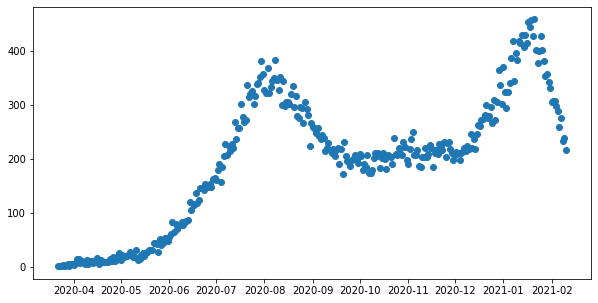

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(df.index.values[0:df.shape[0]],df.values[0:df.shape[0]])

Se escalan los datos y se crean las ventanas

In [ ]:
data = df.copy()
data = data.values.reshape((df.shape[0],1))
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
data_escalado = sc.fit_transform(data)
n = int(data_escalado.shape[0]*0.7)
set_entrenamiento = data_escalado[:n]
set_test = data_escalado[n:]
set_entrenamiento_escalado = set_entrenamiento.reshape(set_entrenamiento.shape[0])
set_test_escalado = set_test.reshape(set_test.shape[0])
def windowed_dataset(series, window_size=20, batch_size=32, shuffle_buffer=1000):
    # convert the series to tensor format
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # create the windows shifted 1 position, 
    #drop_remainder keeps the number of elements in the window the same size.
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    # convert each window to numpy vector format
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    # shuffle the data
    if (shuffle_buffer is not 0):
      print("shuffle")
      dataset = dataset.shuffle(shuffle_buffer)
    # Generate the batches
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

window_size=7
train_data = windowed_dataset(set_entrenamiento_escalado, window_size, batch_size=16, shuffle_buffer=100)

shuffle


In [ ]:
#@title **code** Building  the RNN model

# Define the layers ######################################################## 
lambda_input = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                                      name='InputTransform')
# return sequences to feed to the next RNN layer
simpleRNN1 = tf.keras.layers.SimpleRNN(units=20,
                                       return_sequences=True,
                                       activation=tf.keras.activations.tanh,
                                       name='RNN_layer1')

simpleRNN2 = tf.keras.layers.SimpleRNN(units=20,
                                       return_sequences=False,
                                       activation=tf.keras.activations.tanh,
                                       name='RNN_layer2')
# To calculate the output value
dense1 = tf.keras.layers.Dense(units=32,
                              activation=tf.keras.activations.relu,
                              name='dense_layer')
dense = tf.keras.layers.Dense(units=1,
                              activation=tf.keras.activations.linear,
                              name='ouput_layer')
############################################################################
# Create the model
input_ = tf.keras.layers.Input(window_size)
input_transform = lambda_input(input_)
x = simpleRNN1(input_transform)
x = simpleRNN2(x)
x = dense1(x)
y = dense(x)
############################################################################

model_1 = tf.keras.Model(inputs=input_, outputs=y)
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
InputTransform (Lambda)      (None, 7, 1)              0         
_________________________________________________________________
RNN_layer1 (SimpleRNN)       (None, 7, 20)             440       
_________________________________________________________________
RNN_layer2 (SimpleRNN)       (None, 20)                820       
_________________________________________________________________
dense_layer (Dense)          (None, 32)                672       
_________________________________________________________________
ouput_layer (Dense)          (None, 1)                 33        
Total params: 1,965
Trainable params: 1,965
Non-trainable params: 0
___________________________________________________________

Epoch 1/50
7/7 [==============================] - 1s 7ms/step - loss: 3.8531 - mse: 3.8531 - mae: 1.8065
Epoch 2/50
7/7 [==============================] - 0s 6ms/step - loss: 2.4515 - mse: 2.4515 - mae: 1.4175
Epoch 3/50
7/7 [==============================] - 0s 7ms/step - loss: 1.4353 - mse: 1.4353 - mae: 1.0670
Epoch 4/50
7/7 [==============================] - 0s 7ms/step - loss: 0.7360 - mse: 0.7360 - mae: 0.7574
Epoch 5/50
7/7 [==============================] - 0s 6ms/step - loss: 0.3897 - mse: 0.3897 - mae: 0.5509
Epoch 6/50
7/7 [==============================] - 0s 7ms/step - loss: 0.2494 - mse: 0.2494 - mae: 0.4415
Epoch 7/50
7/7 [==============================] - 0s 7ms/step - loss: 0.1663 - mse: 0.1663 - mae: 0.3611
Epoch 8/50
7/7 [==============================] - 0s 7ms/step - loss: 0.1103 - mse: 0.1103 - mae: 0.2948
Epoch 9/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0751 - mse: 0.0751 - mae: 0.2418
Epoch 10/50
7/7 [==============================] - 0s 8

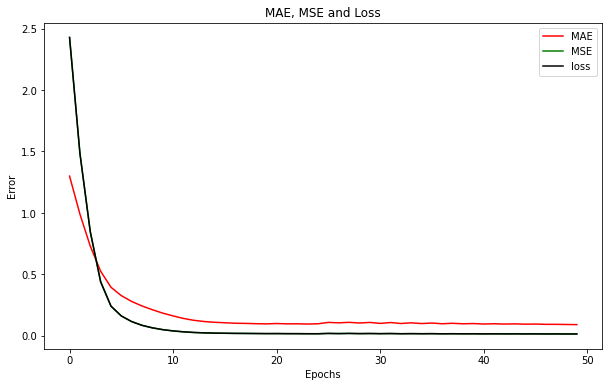

In [ ]:
tf.keras.backend.clear_session()

model_1.compile(loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse', 'mae'],optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4, momentum=0.8))  
# fit
history = model_1.fit(train_data,epochs=50,verbose=1)
loss = history.history['loss']
mae = history.history['mae']
mse = history.history['mse']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE, MSE and Loss
#------------------------------------------------
plt.figure(figsize=(10, 6));
plt.plot(epochs, mae, 'red', label='MAE')
plt.plot(epochs, mse, 'green', label='MSE')
plt.plot(epochs, loss, 'black', label='loss')
plt.title('MAE, MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend();
plt.show();

(220, 1) (91, 1)
(220, 1)


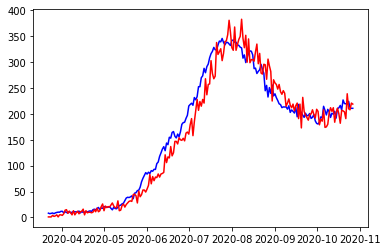

In [ ]:
train_data = windowed_dataset(set_entrenamiento_escalado, window_size, batch_size=16, shuffle_buffer=0)
test_data = windowed_dataset(set_test_escalado, window_size, batch_size=16, shuffle_buffer=0)

train_covid  = model_1.predict(train_data)
test_covid  = model_1.predict(test_data)
print(train_covid.shape, test_covid.shape)


train_pred = sc.inverse_transform(train_covid)

time = df.index.values
print(train_pred.shape)
plt.plot(time[0:train_pred.shape[0]], train_pred[:,0],color='blue', label='predicted')
plt.plot(time[0:train_pred.shape[0]], data[0:train_pred.shape[0]], color='red', label='real')

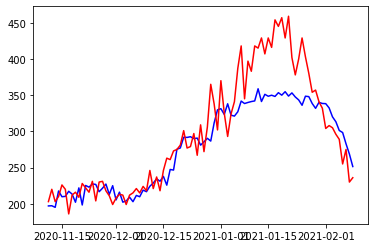

In [ ]:
pred_test = sc.inverse_transform(test_covid)
plt.plot(time[-test_covid.shape[0]:], pred_test[:,0],color='blue', label='predicted')
plt.plot(time[-test_covid.shape[0]:], data[len(data)-len(pred_test):],color='red', label='real')

In [ ]:
def make_predictions(n_predictions, model, test_data):
  prediction = np.zeros(n_predictions)
  X = test_data[-(7+1):]
  for i in range(n_predictions):
    new_data = windowed_dataset(X, 7, batch_size=1, shuffle_buffer=0)
    new_prediction = model.predict(new_data).squeeze()
    prediction[i] = new_prediction
    X = np.r_[X[1:], new_prediction]

  prediction = sc.inverse_transform(prediction[...,np.newaxis]).squeeze()


  return prediction

predictions=make_predictions(100, model_1, set_test_escalado)

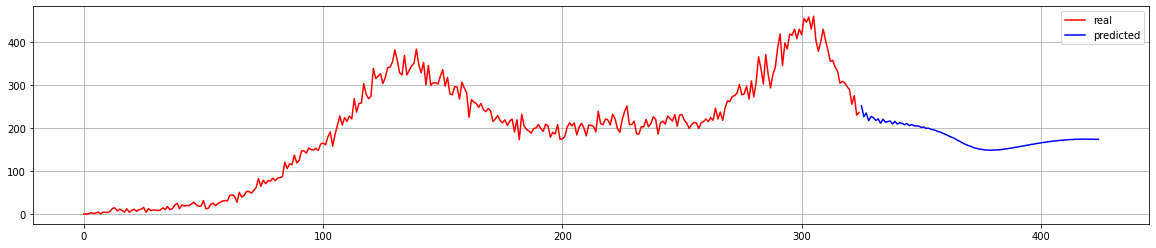

In [ ]:
def plot_predictions(data, prediction):
  tam = len(data)
  plt.figure(figsize=(20, 4))
  plt.plot(data, color='red', label='real')
  plt.plot(np.arange(tam, tam + 100), prediction, color='blue', label='predicted')
  plt.legend()
  plt.grid()
  plt.show()
plot_predictions(df.values, predictions)

## Multivariado

Se cargan los datos completos para seleccionar varios

In [ ]:
data = pd.read_csv('https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv?accessType=DOWNLOAD')
def to_t_series(data, nombre, fechas):
  time_series = pd.DataFrame(columns=[nombre], index=fechas)

  for dia in time_series.index:
    fecha_auxiliar = data[data.index == dia]
    if not fecha_auxiliar.empty:
      time_series[nombre][dia] = fecha_auxiliar.values[0]

  time_series = time_series.fillna(0)

  return time_series
data.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (14,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,fecha reporte web,ID de caso,Fecha de notificación,Código DIVIPOLA departamento,Nombre departamento,Código DIVIPOLA municipio,Nombre municipio,Edad,Unidad de medida de edad,Sexo,Tipo de contagio,Ubicación del caso,Estado,Código ISO del país,Nombre del país,Recuperado,Fecha de inicio de síntomas,Fecha de muerte,Fecha de diagnóstico,Fecha de recuperación,Tipo de recuperación,Pertenencia étnica,Nombre del grupo étnico
0,6/3/2020 0:00:00,1,2/3/2020 0:00:00,11,BOGOTA,11001,BOGOTA,19,1,F,Importado,Casa,Leve,380.0,ITALIA,Recuperado,27/2/2020 0:00:00,NaN,6/3/2020 0:00:00,13/3/2020 0:00:00,PCR,6.0,NaN
1,9/3/2020 0:00:00,2,6/3/2020 0:00:00,76,VALLE,76111,BUGA,34,1,M,Importado,Casa,Leve,724.0,ESPAÑA,Recuperado,4/3/2020 0:00:00,NaN,9/3/2020 0:00:00,19/3/2020 0:00:00,PCR,5.0,NaN
2,9/3/2020 0:00:00,3,7/3/2020 0:00:00,5,ANTIOQUIA,5001,MEDELLIN,50,1,F,Importado,Casa,Leve,724.0,ESPAÑA,Recuperado,29/2/2020 0:00:00,NaN,9/3/2020 0:00:00,15/3/2020 0:00:00,PCR,6.0,NaN
3,11/3/2020 0:00:00,4,9/3/2020 0:00:00,5,ANTIOQUIA,5001,MEDELLIN,55,1,M,Relacionado,Casa,Leve,NaN,NaN,Recuperado,6/3/2020 0:00:00,NaN,11/3/2020 0:00:00,26/3/2020 0:00:00,PCR,6.0,NaN
4,11/3/2020 0:00:00,5,9/3/2020 0:00:00,5,ANTIOQUIA,5001,MEDELLIN,25,1,M,Relacionado,Casa,Leve,NaN,NaN,Recuperado,8/3/2020 0:00:00,NaN,11/3/2020 0:00:00,23/3/2020 0:00:00,PCR,6.0,NaN


Se crea la serie de tiempo con varios features

In [ ]:
data["Fecha de muerte"] = pd.to_datetime(data["Fecha de muerte"], format="%d/%m/%Y  %H:%M:%S")
data['Fecha de notificación'] = pd.to_datetime(data['Fecha de notificación'], format="%d/%m/%Y  %H:%M:%S", errors='coerce')
data['Fecha de inicio de síntomas'] = pd.to_datetime(data['Fecha de inicio de síntomas'], format="%d/%m/%Y  %H:%M:%S", errors='coerce')
data['Fecha de recuperación'] = pd.to_datetime(data['Fecha de recuperación'], format="%d/%m/%Y  %H:%M:%S", errors='coerce')

fecha_inicial, fecha_final = data['Fecha de notificación'][0], pd.Timestamp.today()
fechas = pd.date_range(fecha_inicial, fecha_final).tolist()

muerte=data.pivot_table(index=['Fecha de muerte'], aggfunc='size')
notificacion = data.pivot_table(index=['Fecha de notificación'], aggfunc='size')
FIS = data.pivot_table(index=['Fecha de inicio de síntomas'], aggfunc='size')
recuperado = data.pivot_table(index=['Fecha de recuperación'], aggfunc='size')

muerte_series = to_t_series(muerte, 'Cantidad de muertes', fechas)
notificacion_series = to_t_series(notificacion, 'Cantidad de notificados', fechas)
FIS_series = to_t_series(FIS, 'FIS', fechas)
recuperado_series = to_t_series(recuperado, 'Cantidad de recuperados', fechas)

multi_df = pd.concat((notificacion_series, FIS_series, recuperado_series, muerte_series), axis=1)
multi_df = multi_df[:-4]
multi_df.tail()


,Cantidad de notificados,FIS,Cantidad de recuperados,Cantidad de muertes
2021-02-07,2007,1068,5996,277
2021-02-08,3874,1151,7971,234
2021-02-09,3155,793,15304,239
2021-02-10,2899,603,7990,217
2021-02-11,2212,315,9647,168


In [ ]:
def split_series(time, serie, train_rate=0.5, test_rate=0.25, validation_rate=0.25):
    num_examples = len(serie)
    # split series in train, validation and test sets
    series_split = [serie[:int(num_examples*train_rate)],serie[int(num_examples*train_rate):int(num_examples*(train_rate+validation_rate))+1],serie[int(num_examples*(train_rate+validation_rate))+1:]]
    # split time for train, validation and test series
    time_split = [time[:int(num_examples*train_rate)],time[int(num_examples*train_rate):int(num_examples*(train_rate+validation_rate))+1],time[int(num_examples*(train_rate+validation_rate))+1:]]           
    
    return time_split, series_split
time_sets_multi, series_sets_multi = split_series(time=multi_df.index, serie=multi_df.values, train_rate=0.7, test_rate=0.3)
sc2 = StandardScaler()
#data_escalado = sc2.fit_transform(series_sets_multi)
#n = int(data_escalado.shape[0]*0.7)
set_entrenamiento_escalado = sc2.fit_transform(series_sets_multi[0])
set_test_escalado = sc2.transform(series_sets_multi[1])
#set_entrenamiento_escalado = set_entrenamiento.reshape(set_entrenamiento.shape[0])
#set_test_escalado = set_test.reshape(set_test.shape[0])
window_size=7
train_data = windowed_dataset(set_entrenamiento_escalado, window_size, batch_size=16, shuffle_buffer=100)

shuffle


In [ ]:
#@title **code** Building  the RNN model

# Define the layers ######################################################## 

# return sequences to feed to the next RNN layer
simpleRNN1 = tf.keras.layers.SimpleRNN(units=20,
                                       return_sequences=True,
                                       activation=tf.keras.activations.tanh,
                                       name='RNN_layer1')

simpleRNN2 = tf.keras.layers.SimpleRNN(units=20,
                                       return_sequences=False,
                                       activation=tf.keras.activations.tanh,
                                       name='RNN_layer2')
# To calculate the output value
dense = tf.keras.layers.Dense(units=4,
                              activation=tf.keras.activations.linear,
                              name='ouput_layer')
############################################################################
# Create the model
input_ = tf.keras.layers.Input((window_size, 4))
x = simpleRNN1(input_)
x = simpleRNN2(x)
y = dense(x)
############################################################################

model_2 = tf.keras.Model(inputs=input_, outputs=y)
model_2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 4)]            0         
_________________________________________________________________
RNN_layer1 (SimpleRNN)       (None, 7, 20)             500       
_________________________________________________________________
RNN_layer2 (SimpleRNN)       (None, 20)                820       
_________________________________________________________________
ouput_layer (Dense)          (None, 4)                 84        
Total params: 1,404
Trainable params: 1,404
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
15/15 [==============================] - 2s 5ms/step - loss: 0.6951 - mse: 0.6951 - mae: 0.7186
Epoch 2/50
15/15 [==============================] - 0s 4ms/step - loss: 0.2163 - mse: 0.2163 - mae: 0.3401
Epoch 3/50
15/15 [==============================] - 0s 5ms/step - loss: 0.1640 - mse: 0.1640 - mae: 0.2878
Epoch 4/50
15/15 [==============================] - 0s 4ms/step - loss: 0.1246 - mse: 0.1246 - mae: 0.2427
Epoch 5/50
15/15 [==============================] - 0s 5ms/step - loss: 0.1123 - mse: 0.1123 - mae: 0.2332
Epoch 6/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0858 - mse: 0.0858 - mae: 0.2015
Epoch 7/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0833 - mse: 0.0833 - mae: 0.1881
Epoch 8/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0722 - mse: 0.0722 - mae: 0.1763
Epoch 9/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0620 - mse: 0.0620 - mae: 0.1555
Epoch 10/50
15/15 [==================

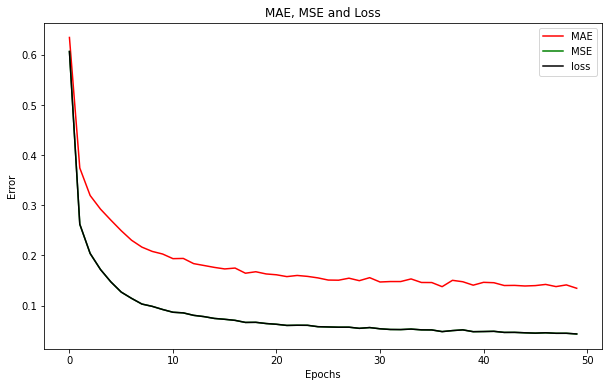

In [ ]:
tf.keras.backend.clear_session()

model_2.compile(loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse', 'mae'],optimizer=tf.keras.optimizers.RMSprop())  
# fit
history = model_2.fit(train_data,epochs=50,verbose=1)
loss = history.history['loss']
mae = history.history['mae']
mse = history.history['mse']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE, MSE and Loss
#------------------------------------------------
plt.figure(figsize=(10, 6));
plt.plot(epochs, mae, 'red', label='MAE')
plt.plot(epochs, mse, 'green', label='MSE')
plt.plot(epochs, loss, 'black', label='loss')
plt.title('MAE, MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend();
plt.show();

(235,)


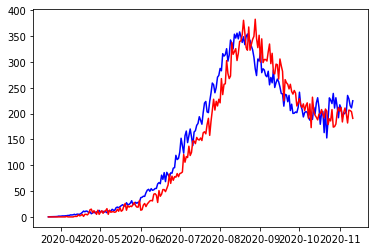

In [ ]:
train_data = windowed_dataset(set_entrenamiento_escalado, window_size, batch_size=16, shuffle_buffer=0)
test_data = windowed_dataset(set_test_escalado, window_size, batch_size=16, shuffle_buffer=0)

train_covid  = model_2.predict(train_data)
test_covid  = model_2.predict(test_data)


train_pred = sc2.inverse_transform(train_covid)[:,-1].squeeze()
time = df.index.values
print(train_pred.shape)
plt.plot(time[0:train_pred.shape[0]], train_pred[:],color='blue', label='predicted')
plt.plot(time[0:train_pred.shape[0]], series_sets_multi[0][...,-1][:train_pred.shape[0]], color='red', label='real')

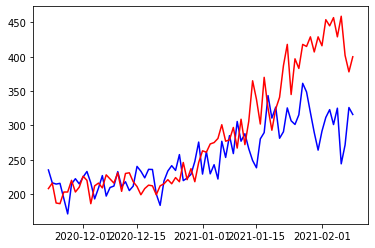

In [ ]:
pred_test = sc2.inverse_transform(test_covid)[:,-1].squeeze()
plt.plot(time[-pred_test.shape[0]:], pred_test[:],color='blue', label='predicted')
plt.plot(time[-pred_test.shape[0]:], series_sets_multi[1][...,-1][-pred_test.shape[0]:],color='red', label='real')

In [ ]:
def make_predictions(n_predictions, model, test_data):
  prediction = np.zeros((n_predictions,4))
  X = test_data[-(7+1):]
  for i in range(n_predictions):
    new_data = windowed_dataset(X, 7, batch_size=1, shuffle_buffer=0)
    new_prediction = model.predict(new_data).squeeze()
    prediction[i] = new_prediction
    X = np.vstack((X[1:, :], new_prediction))

  prediction = sc2.inverse_transform(prediction).squeeze()



  return prediction

predictions=make_predictions(100, model_2, set_test_escalado)

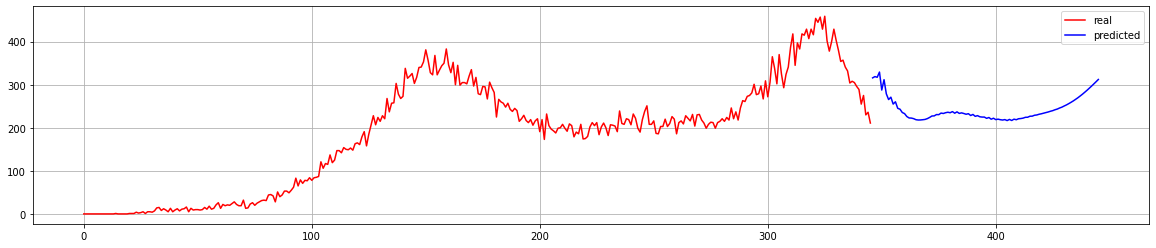

In [ ]:
def plot_predictions(data, prediction):
  tam = len(data)
  plt.figure(figsize=(20, 4))
  plt.plot(data, color='red', label='real')
  plt.plot(np.arange(tam, tam + 100), prediction, color='blue', label='predicted')
  plt.legend()
  plt.grid()
  plt.show()
plot_predictions(multi_df.values[:,-1], predictions[:,-1])

Se observa que ambos modelos obtuvieron un resultado similar con buen resultado para el training y uno aceptable para test. 

# **2. Propose a RNN to forecasting performance of main EEUU industries (DJIA)**

In this [DJIA](https://www.kaggle.com/szrlee/stock-time-series-20050101-to-20171231?select=WMT_2006-01-01_to_2018-01-01.csv) select one time serie for any enterprise. Then propose a single and multivariate RNN architecture to forecasting performance in global market. 

1. Select a temporal serie and annotate in this [document](https://docs.google.com/spreadsheets/d/1IkDVr9eOSispScnJrLDb3k_shdivXDzjrJ1Cr77Yjq8/edit?usp=sharing)
2. Use training -test configurations, from training (90\%)
3. use a single and multivate RNN version. For multivariate version proof with
  - Feature from same dataset (almost three)
  - Features from other temporal series at same time (almost three)
4. Plot results and report MAE errors. 

More information about DJIA is [here](https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average)

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"brayanbarajas","key":"47252eef2cec81a60026d291860870b5"}'}

In [ ]:
!ls -lha kaggle.json
!mkdir -p ~/.kaggle/
!cp kaggle.json ~/.kaggle
# This permissions change avoids a warning on Kaggle tool startup
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 69 Feb 15 00:50 kaggle.json


In [ ]:
#install in case it's not installed
#!pip install -q kaggle
!kaggle datasets download -d szrlee/stock-time-series-20050101-to-20171231 -f MCD_2006-01-01_to_2018-01-01.csv
!kaggle datasets download -d szrlee/stock-time-series-20050101-to-20171231 -f DIS_2006-01-01_to_2018-01-01.csv
!kaggle datasets download -d szrlee/stock-time-series-20050101-to-20171231 -f AAPL_2006-01-01_to_2018-01-01.csv
!kaggle datasets download -d szrlee/stock-time-series-20050101-to-20171231 -f AMZN_2006-01-01_to_2018-01-01.csv
#!unzip stock-time-series-20050101-to-20171231.zip -d /content/Data # cambiar el nombre de archivo .zip

MCD_2006-01-01_to_2018-01-01.csv: Skipping, found more recently modified local copy (use --force to force download)
DIS_2006-01-01_to_2018-01-01.csv: Skipping, found more recently modified local copy (use --force to force download)
AAPL_2006-01-01_to_2018-01-01.csv: Skipping, found more recently modified local copy (use --force to force download)
AMZN_2006-01-01_to_2018-01-01.csv: Skipping, found more recently modified local copy (use --force to force download)


## RNN Single

In [ ]:
MCD = pd.read_csv("MCD_2006-01-01_to_2018-01-01.csv")
MCD.index = pd.DatetimeIndex(MCD.Date)
MCD_single=MCD['Open']
MCD_single.head()

Date
2006-01-03    34.29
2006-01-04    33.43
2006-01-05    33.82
2006-01-06    34.23
2006-01-09    34.00
Name: Open, dtype: float64

In [ ]:
data = MCD_single.copy()
data = data.values.reshape((MCD_single.shape[0],1))
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
data_escalado = sc.fit_transform(data)
n = int(data_escalado.shape[0]*0.9)
set_entrenamiento = data_escalado[:n]
set_test = data_escalado[n:]
set_entrenamiento_escalado = set_entrenamiento.reshape(set_entrenamiento.shape[0])
set_test_escalado = set_test.reshape(set_test.shape[0])

window_size=7
train_data = windowed_dataset(set_entrenamiento_escalado, window_size, batch_size=16, shuffle_buffer=100)

shuffle


In [ ]:
#@title **code** Building  the RNN model

# Define the layers ######################################################## 
lambda_input = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                                      name='InputTransform')
# return sequences to feed to the next RNN layer
simpleRNN1 = tf.keras.layers.SimpleRNN(units=20,
                                       return_sequences=True,
                                       activation=tf.keras.activations.tanh,
                                       name='RNN_layer1')

simpleRNN2 = tf.keras.layers.SimpleRNN(units=20,
                                       return_sequences=False,
                                       activation=tf.keras.activations.tanh,
                                       name='RNN_layer2')
# To calculate the output value
dense1 = tf.keras.layers.Dense(units=32,
                              activation=tf.keras.activations.relu,
                              name='dense_layer')
dense = tf.keras.layers.Dense(units=1,
                              activation=tf.keras.activations.linear,
                              name='ouput_layer')
############################################################################
# Create the model
input_ = tf.keras.layers.Input(window_size)
input_transform = lambda_input(input_)
x = simpleRNN1(input_transform)
x = simpleRNN2(x)
x = dense1(x)
y = dense(x)
############################################################################

model_simple2 = tf.keras.Model(inputs=input_, outputs=y)
model_simple2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
InputTransform (Lambda)      (None, 7, 1)              0         
_________________________________________________________________
RNN_layer1 (SimpleRNN)       (None, 7, 20)             440       
_________________________________________________________________
RNN_layer2 (SimpleRNN)       (None, 20)                820       
_________________________________________________________________
dense_layer (Dense)          (None, 32)                672       
_________________________________________________________________
ouput_layer (Dense)          (None, 1)                 33        
Total params: 1,965
Trainable params: 1,965
Non-trainable params: 0
___________________________________________________________

Epoch 1/50
170/170 [==============================] - 2s 4ms/step - loss: 1.5607 - mse: 1.5607 - mae: 0.8281
Epoch 2/50
170/170 [==============================] - 1s 5ms/step - loss: 0.3475 - mse: 0.3475 - mae: 0.3306
Epoch 3/50
170/170 [==============================] - 1s 5ms/step - loss: 0.0490 - mse: 0.0490 - mae: 0.1219
Epoch 4/50
170/170 [==============================] - 1s 5ms/step - loss: 0.0064 - mse: 0.0064 - mae: 0.0522
Epoch 5/50
170/170 [==============================] - 1s 5ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0345
Epoch 6/50
170/170 [==============================] - 1s 5ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0277
Epoch 7/50
170/170 [==============================] - 1s 5ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0253
Epoch 8/50
170/170 [==============================] - 1s 5ms/step - loss: 9.7509e-04 - mse: 9.7509e-04 - mae: 0.0231
Epoch 9/50
170/170 [==============================] - 1s 5ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0248
Epoch 10/50

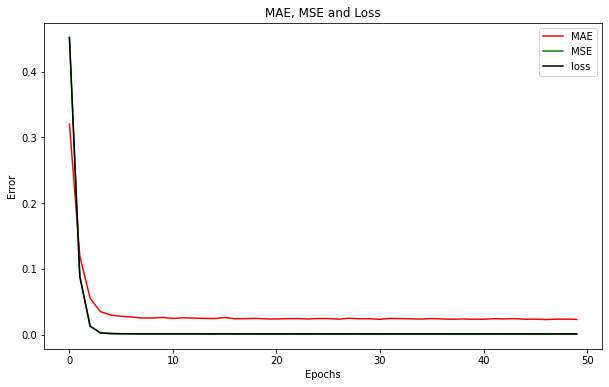

In [ ]:
tf.keras.backend.clear_session()

model_simple2.compile(loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse', 'mae'],optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4, momentum=0.8))  
# fit
history = model_simple2.fit(train_data,epochs=50,verbose=1)
loss = history.history['loss']
mae = history.history['mae']
mse = history.history['mse']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE, MSE and Loss
#------------------------------------------------
plt.figure(figsize=(10, 6));
plt.plot(epochs, mae, 'red', label='MAE')
plt.plot(epochs, mse, 'green', label='MSE')
plt.plot(epochs, loss, 'black', label='loss')
plt.title('MAE, MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend();
plt.show();

(2711, 1) (295, 1)
(2711, 1)


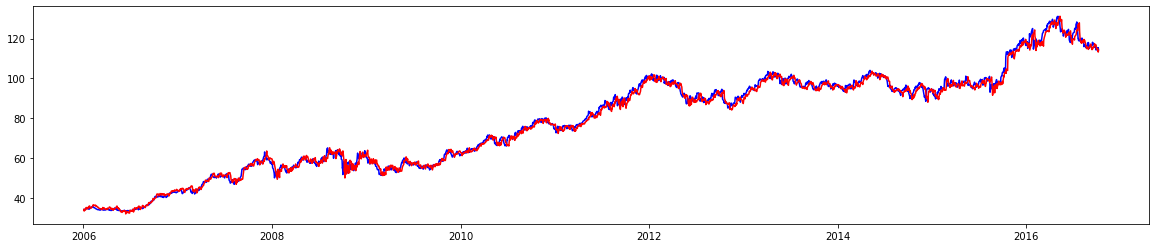

In [ ]:
train_data = windowed_dataset(set_entrenamiento_escalado, window_size, batch_size=16, shuffle_buffer=0)
test_data = windowed_dataset(set_test_escalado, window_size, batch_size=16, shuffle_buffer=0)

train_plt  = model_simple2.predict(train_data)
test_plt  = model_simple2.predict(test_data)
print(train_plt.shape, test_plt.shape)


train_pred = sc.inverse_transform(train_plt)

time = MCD_single.index.values
print(train_pred.shape)
plt.figure(figsize=(20, 4))
plt.plot(time[0:train_pred.shape[0]], train_pred[:,0],color='blue', label='predicted')
plt.plot(time[0:train_pred.shape[0]], data[0:train_pred.shape[0]], color='red', label='real')

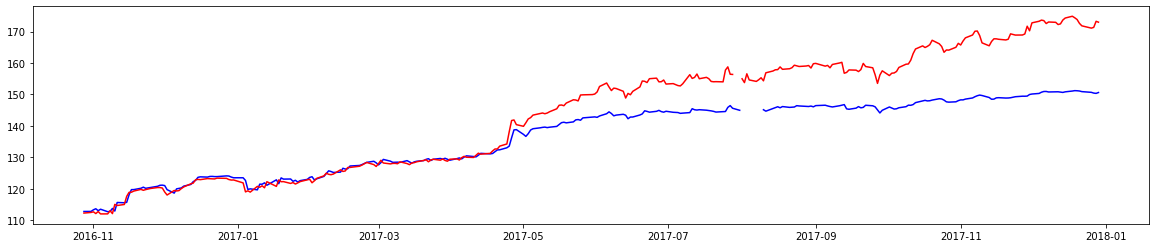

In [ ]:
pred_test = sc.inverse_transform(test_plt)
plt.figure(figsize=(20, 4))
plt.plot(time[-test_plt.shape[0]:], pred_test[:,0],color='blue', label='predicted')
plt.plot(time[-test_plt.shape[0]:], data[-len(pred_test):],color='red', label='real')

## RNN multivariada con información del mismo Stock

In [ ]:
MCD_multi1=MCD[['Open','High','Low','Close']]
MCD_multi1.head()

,Open,High,Low,Close
Date,,,,
2006-01-03,34.29,34.29,33.20,33.52
2006-01-04,33.43,33.85,33.42,33.82
2006-01-05,33.82,34.20,33.73,33.86
2006-01-06,34.23,34.30,33.81,34.06
2006-01-09,34.00,34.74,33.99,34.71


In [ ]:
time_sets_multi, series_sets_multi = split_series(time=MCD_multi1.index, serie=MCD_multi1.values, train_rate=0.7, test_rate=0.3)
sc2 = StandardScaler()
#data_escalado = sc2.fit_transform(series_sets_multi)
#n = int(data_escalado.shape[0]*0.7)
set_entrenamiento_escalado = sc2.fit_transform(series_sets_multi[0])
set_test_escalado = sc2.transform(series_sets_multi[1])
#set_entrenamiento_escalado = set_entrenamiento.reshape(set_entrenamiento.shape[0])
#set_test_escalado = set_test.reshape(set_test.shape[0])
window_size=7
train_data = windowed_dataset(set_entrenamiento_escalado, window_size, batch_size=16, shuffle_buffer=100)

shuffle


In [ ]:
#@title **code** Building  the RNN model

# Define the layers ######################################################## 

# return sequences to feed to the next RNN layer
simpleRNN1 = tf.keras.layers.SimpleRNN(units=20,
                                       return_sequences=True,
                                       activation=tf.keras.activations.tanh,
                                       name='RNN_layer1')

simpleRNN2 = tf.keras.layers.SimpleRNN(units=20,
                                       return_sequences=False,
                                       activation=tf.keras.activations.tanh,
                                       name='RNN_layer2')
# To calculate the output value
dense = tf.keras.layers.Dense(units=4,
                              activation=tf.keras.activations.linear,
                              name='ouput_layer')
############################################################################
# Create the model
input_ = tf.keras.layers.Input((window_size, 4))
x = simpleRNN1(input_)
x = simpleRNN2(x)
y = dense(x)
############################################################################

model_multi1 = tf.keras.Model(inputs=input_, outputs=y)
model_multi1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 4)]            0         
_________________________________________________________________
RNN_layer1 (SimpleRNN)       (None, 7, 20)             500       
_________________________________________________________________
RNN_layer2 (SimpleRNN)       (None, 20)                820       
_________________________________________________________________
ouput_layer (Dense)          (None, 4)                 84        
Total params: 1,404
Trainable params: 1,404
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
132/132 [==============================] - 2s 5ms/step - loss: 0.3914 - mse: 0.3914 - mae: 0.3848
Epoch 2/50
132/132 [==============================] - 1s 5ms/step - loss: 0.0124 - mse: 0.0124 - mae: 0.0866
Epoch 3/50
132/132 [==============================] - 1s 5ms/step - loss: 0.0077 - mse: 0.0077 - mae: 0.0694
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.0062 - mse: 0.0062 - mae: 0.0616
Epoch 5/50
132/132 [==============================] - 1s 5ms/step - loss: 0.0051 - mse: 0.0051 - mae: 0.0554
Epoch 6/50
132/132 [==============================] - 1s 5ms/step - loss: 0.0047 - mse: 0.0047 - mae: 0.0528
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0482
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0476
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0470
Epoch 10/50
132/132

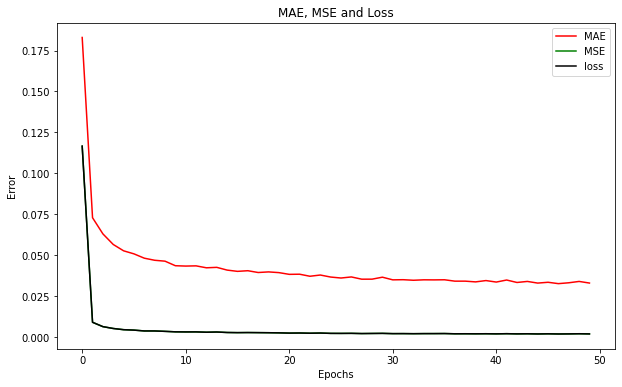

In [ ]:
tf.keras.backend.clear_session()

model_multi1.compile(loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse', 'mae'],optimizer=tf.keras.optimizers.RMSprop())  
# fit
history = model_multi1.fit(train_data,epochs=50,verbose=1)
loss = history.history['loss']
mae = history.history['mae']
mse = history.history['mse']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE, MSE and Loss
#------------------------------------------------
plt.figure(figsize=(10, 6));
plt.plot(epochs, mae, 'red', label='MAE')
plt.plot(epochs, mse, 'green', label='MSE')
plt.plot(epochs, loss, 'black', label='loss')
plt.title('MAE, MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend();
plt.show();

(2107,)


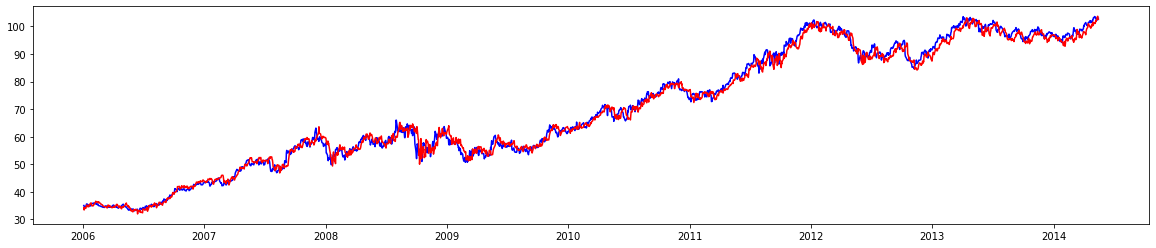

In [ ]:
train_data = windowed_dataset(set_entrenamiento_escalado, window_size, batch_size=16, shuffle_buffer=0)
test_data = windowed_dataset(set_test_escalado, window_size, batch_size=16, shuffle_buffer=0)

train_plt  = model_multi1.predict(train_data)
test_plt  = model_multi1.predict(test_data)


train_pred = sc2.inverse_transform(train_plt)[:,0].squeeze()
time = MCD_multi1.index.values
print(train_pred.shape)
plt.figure(figsize=(20, 4))
plt.plot(time[0:train_pred.shape[0]], train_pred[:],color='blue', label='predicted')
plt.plot(time[0:train_pred.shape[0]], series_sets_multi[0][...,0][:train_pred.shape[0]], color='red', label='real')

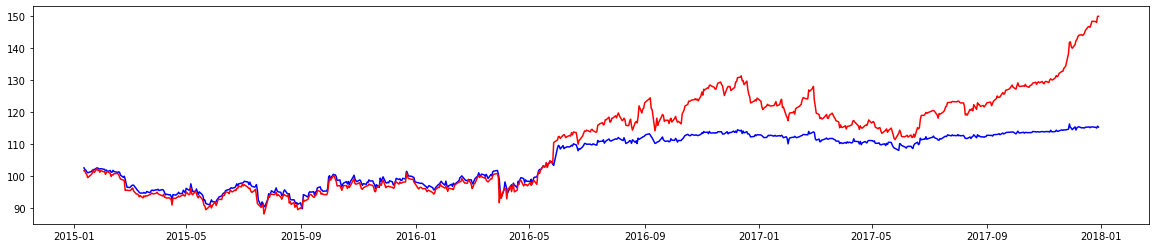

In [ ]:
pred_test = sc2.inverse_transform(test_plt)[:,0].squeeze()
plt.figure(figsize=(20, 4))
plt.plot(time[-pred_test.shape[0]:], pred_test[:],color='blue', label='predicted')
plt.plot(time[-pred_test.shape[0]:], series_sets_multi[1][...,0][-pred_test.shape[0]:],color='red', label='real')

## RNN multivariada con información de múltiples stocks

In [ ]:
DIS = pd.read_csv("DIS_2006-01-01_to_2018-01-01.csv")
DIS.index = pd.DatetimeIndex(DIS.Date)
DIS=DIS['Open']
AAPL = pd.read_csv("AAPL_2006-01-01_to_2018-01-01.csv")
AAPL.index = pd.DatetimeIndex(AAPL.Date)
AAPL=AAPL['Open']
AMZN = pd.read_csv("AMZN_2006-01-01_to_2018-01-01.csv")
AMZN.index = pd.DatetimeIndex(AMZN.Date)
AMZN=AMZN['Open']
multi2 = pd.concat([DIS, AAPL, AMZN, MCD_single], axis=1 )
multi2 = multi2.dropna()
multi2.columns=['Open_DIS','Open_AAPL','Open_AMZN','Open_MCD']
multi2.head()

,Open_DIS,Open_AAPL,Open_AMZN,Open_MCD
Date,,,,
2006-01-03,24.08,10.34,47.47,34.29
2006-01-04,24.50,10.73,47.48,33.43
2006-01-05,24.13,10.69,47.16,33.82
2006-01-06,24.65,10.75,47.97,34.23
2006-01-09,24.85,10.96,46.55,34.00


In [ ]:
time_sets_multi, series_sets_multi = split_series(time=multi2.index, serie=multi2.values, train_rate=0.7, test_rate=0.3)
sc3 = StandardScaler()
#data_escalado = sc2.fit_transform(series_sets_multi)
#n = int(data_escalado.shape[0]*0.7)
set_entrenamiento_escalado = sc3.fit_transform(series_sets_multi[0])
set_test_escalado = sc3.transform(series_sets_multi[1])
#set_entrenamiento_escalado = set_entrenamiento.reshape(set_entrenamiento.shape[0])
#set_test_escalado = set_test.reshape(set_test.shape[0])
window_size=7
train_data = windowed_dataset(set_entrenamiento_escalado, window_size, batch_size=16, shuffle_buffer=100)

shuffle


In [ ]:
#@title **code** Building  the RNN model

# Define the layers ######################################################## 

# return sequences to feed to the next RNN layer
simpleRNN1 = tf.keras.layers.SimpleRNN(units=20,
                                       return_sequences=True,
                                       activation=tf.keras.activations.tanh,
                                       name='RNN_layer1')

simpleRNN2 = tf.keras.layers.SimpleRNN(units=20,
                                       return_sequences=False,
                                       activation=tf.keras.activations.tanh,
                                       name='RNN_layer2')
# To calculate the output value
dense = tf.keras.layers.Dense(units=4,
                              activation=tf.keras.activations.linear,
                              name='ouput_layer')
############################################################################
# Create the model
input_ = tf.keras.layers.Input((window_size, 4))
x = simpleRNN1(input_)
x = simpleRNN2(x)
y = dense(x)
############################################################################

model_multi2 = tf.keras.Model(inputs=input_, outputs=y)
model_multi2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 4)]            0         
_________________________________________________________________
RNN_layer1 (SimpleRNN)       (None, 7, 20)             500       
_________________________________________________________________
RNN_layer2 (SimpleRNN)       (None, 20)                820       
_________________________________________________________________
ouput_layer (Dense)          (None, 4)                 84        
Total params: 1,404
Trainable params: 1,404
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
132/132 [==============================] - 2s 4ms/step - loss: 0.2385 - mse: 0.2385 - mae: 0.3255
Epoch 2/50
132/132 [==============================] - 1s 5ms/step - loss: 0.0192 - mse: 0.0192 - mae: 0.1081
Epoch 3/50
132/132 [==============================] - 1s 5ms/step - loss: 0.0132 - mse: 0.0132 - mae: 0.0835
Epoch 4/50
132/132 [==============================] - 1s 5ms/step - loss: 0.0110 - mse: 0.0110 - mae: 0.0783
Epoch 5/50
132/132 [==============================] - 1s 5ms/step - loss: 0.0084 - mse: 0.0084 - mae: 0.0701
Epoch 6/50
132/132 [==============================] - 1s 5ms/step - loss: 0.0077 - mse: 0.0077 - mae: 0.0645
Epoch 7/50
132/132 [==============================] - 1s 5ms/step - loss: 0.0063 - mse: 0.0063 - mae: 0.0616
Epoch 8/50
132/132 [==============================] - 1s 5ms/step - loss: 0.0060 - mse: 0.0060 - mae: 0.0588
Epoch 9/50
132/132 [==============================] - 1s 5ms/step - loss: 0.0054 - mse: 0.0054 - mae: 0.0564
Epoch 10/50
132/132

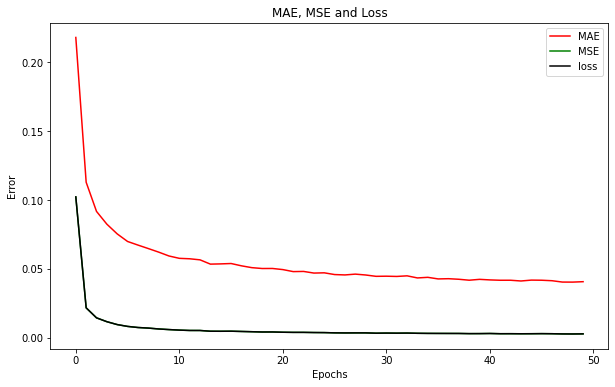

In [ ]:
tf.keras.backend.clear_session()

model_multi2.compile(loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse', 'mae'],optimizer=tf.keras.optimizers.RMSprop())  
# fit
history = model_multi2.fit(train_data,epochs=50,verbose=1)
loss = history.history['loss']
mae = history.history['mae']
mse = history.history['mse']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE, MSE and Loss
#------------------------------------------------
plt.figure(figsize=(10, 6));
plt.plot(epochs, mae, 'red', label='MAE')
plt.plot(epochs, mse, 'green', label='MSE')
plt.plot(epochs, loss, 'black', label='loss')
plt.title('MAE, MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend();
plt.show();

(2104,)


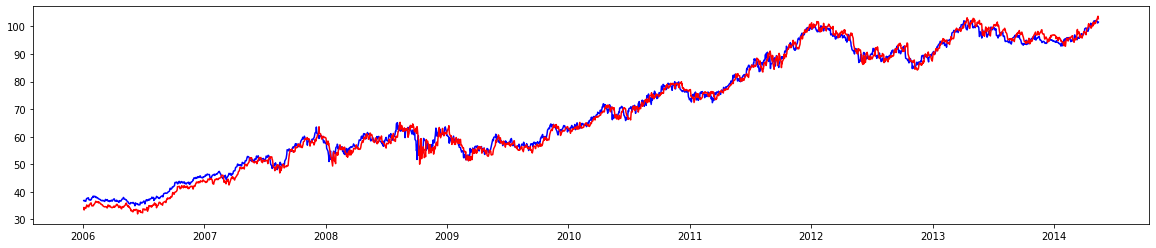

In [ ]:
train_data = windowed_dataset(set_entrenamiento_escalado, window_size, batch_size=16, shuffle_buffer=0)
test_data = windowed_dataset(set_test_escalado, window_size, batch_size=16, shuffle_buffer=0)

train_plt  = model_multi2.predict(train_data)
test_plt  = model_multi2.predict(test_data)


train_pred = sc3.inverse_transform(train_plt)[:,-1].squeeze()
time = multi2.index.values
print(train_pred.shape)
plt.figure(figsize=(20, 4))
plt.plot(time[0:train_pred.shape[0]], train_pred[:],color='blue', label='predicted')
plt.plot(time[0:train_pred.shape[0]], series_sets_multi[0][...,-1][:train_pred.shape[0]], color='red', label='real')

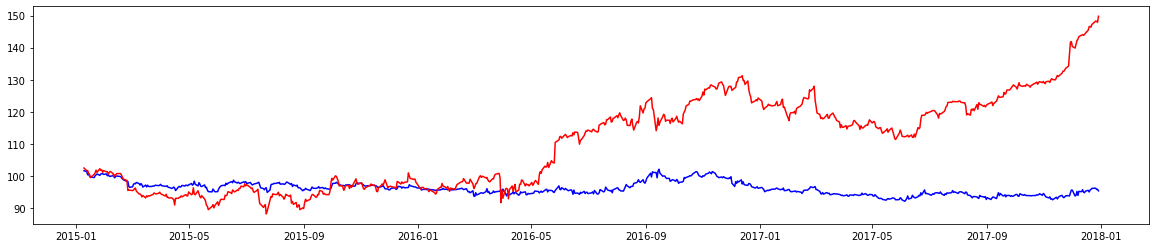

In [ ]:
pred_test = sc3.inverse_transform(test_plt)[:,-1].squeeze()
plt.figure(figsize=(20, 4))
plt.plot(time[-pred_test.shape[0]:], pred_test[:],color='blue', label='predicted')
plt.plot(time[-pred_test.shape[0]:], series_sets_multi[1][...,-1][-pred_test.shape[0]:],color='red', label='real')

Se puede observar que las redes que mejores resultados obtuvieron fueron las que estaban centradas en un único stock. Además, es posible que para obtener mejores resultados se deba aumentar el tamaño de la ventana.

# **3. Propose a RNN, LSTM and GRU for text learning style**

We would like to learn the style of our favorite author (I read almost a book from this author). Then, please fill in this [file](https://docs.google.com/spreadsheets/d/1IkDVr9eOSispScnJrLDb3k_shdivXDzjrJ1Cr77Yjq8/edit?usp=sharing) which is the author and from which document you will learn the style. Almost the text documents should be different for each student. 

Now, build a RNN, LSTM and GRU model with sufficient epochs (more than 100) to learn style. 

- Report obtained results
- Test with almost three phrases and discuss about obtianed results. 
- Compare obtained LSTM and GRU results.

Se leen los datos

In [ ]:
from google.colab import files
files.upload()

Saving Ernesto-Sabato-El-Tunel.pdf to Ernesto-Sabato-El-Tunel.pdf


{'Ernesto-Sabato-El-Tunel.pdf': b'%PDF-1.4\n%\xc7\xec\x8f\xa2\n5 0 obj\n<</Length 6 0 R/Filter /FlateDecode>>\nstream\nx\x9c\xb5\x96K\x8b\x13A\x14\x85\xf11>\xeaW\xd4\xb2\xb3\x98\xb2\xee\xa3\xeec+\x88\xe0n\xa4w\xeaj\xd0\x01!\xc2\xf8\xff\x17\xdenb\x12\xa5kd$\x95\x10R\xd4\xeb\xcb9\xa7n\xa5\xefs-\x80\xb9.\xef\xdf\x8d\xdb}\x82|\x97\x9az\x16\x10,\xa2\x99\xacrF\xa1\xfc\xf3k\xfa\x96j~\x1f\x9f\xbbt\x9f\xac\xd0\xf2Z\x97\x9d\xb7o\xf7\xf9\xed\x9c\xde|\xd4XTb\xe9\x1c\x8b\x8a\xbb3\xf2:\x0e\x19]\x8bbV\xe6\xe2\x98\xe7}\x9a\x9e\xec\xe6\xef\xe9\xdd\x9cn\x8e\xf4f\xee[\xf4\xcb\x90\x81\nI\x8f,\xd4\xce\xc8|Q\xb2\x18\x14\xeb\x81I7\r\xbf\x0c\xb8\xad\x19w\xc8P\xc7\x99-`\xa5\xf5\xccf\xe3qf7\xd3\x1e\xb6\xd98\xab[k\x85\xb6\xac\x96\xda2W\x97\x95\xacj\xa1^\x1eGf;a\x0f\x83\x90A\xa1\xc4@\xabPd=[\x9f\xa6\xa7\xbbZ\x10\xac\x82O\xcfv\xd7\xb5HcW\x8e\x9f\x13msU\x94\xe9\xf9\xee\x1a\n\xb2\xd66]-\xdd\xce.$\xd3\x8b\xa5\x9b*\xf0\xd6\x1e"\xb1\xc5\x97\xf9\xc3\x9f\x92H\t\x8e\x92H\xdac$y^\xea\xf0\xe8\xa4\x1e\x9d\xf4\x82\xe1O8\xc9\x

In [ ]:
!pip install pdfminer.six
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
import io

     |████████████████████████████████| 5.6MB 11.6MB/s 
     |████████████████████████████████| 3.2MB 52.4MB/s 


In [ ]:
def convert_pdf_to_txt(path):
  rsrcmgr = PDFResourceManager()
  retstr = io.StringIO()
  codec = 'utf-8'
  laparams = LAParams()
  device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
  fp = open(path, 'rb')
  interpreter = PDFPageInterpreter(rsrcmgr, device)
  password = ""
  maxpages = 0
  caching = True
  pagenos = set()

  for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages,
                                password=password,
                                caching=caching,
                                check_extractable=True):
      interpreter.process_page(page)

  text = retstr.getvalue()

  fp.close()
  device.close()
  retstr.close()
  return text

Se convierte de pdf a texto

In [ ]:
ElTunel = convert_pdf_to_txt('Ernesto-Sabato-El-Tunel.pdf').replace('\n', '').replace('\x0c', '').replace('-', '').replace('«', '').replace('»', '').replace('Ernesto Sábato','').replace('El tunel','').replace('5','').replace('6','').replace('7','').replace('8','').replace('9','').replace('10','').replace('11','').replace('12','').replace('13','').lower()[233:46743]
ElTunel

'bastará  decir  que  soy  juan  pablo  castel,  el  pintor  que  mató  a  maría iribarne;  supongo  que  el  proceso  está  en  el  recuerdo  de  todos  y  que  no se necesitan mayores explicaciones sobre mi persona. aunque ni el diablo sabe qué es lo que ha de recordar la gente, ni por qué.  en  realidad,  siempre  he  pensado  que  no  hay  memoria  colectiva,  lo que quizá sea una forma de defensa de la especie humana. la frase "todo tiempo  pasado  fue  mejor"  no  indica  que  antes  sucedieran  menos  cosas malas, sino que —felizmente— la gente las echa en el olvido. desde luego, semejante  frase  no  tiene  validez  universal;  yo,  por  ejemplo,  me caracterizo  por  recordar  preferentemente  los  hechos  malos  y,  así,  casi podría  decir  que  "todo  tiempo  pasado  fue  peor",  si  no  fuera  porque  el presente  me  parece  tan  horrible  como  el  pasado;  recuerdo  tantas calamidades,  tantos rostros cínicos y crueles, tantas malas acciones, que la  memoria  es  para  

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple
import nltk
nltk.download('punkt')

2.4.1
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Se crean los tokens

In [ ]:
text = ElTunel
tokens = nltk.word_tokenize(text, preserve_line=False)
text = " ".join(tokens)
sentences = text.split('.')
sentences = [s+' .' for s in sentences]

def counter_sentences_words(sentences):
  n_sentences = len(sentences)
  words_sentence = [len(s.split(' ')) for s in sentences]
  n_words = np.sum(words_sentence)
  n_words_max = np.max(words_sentence)
  
  return n_sentences, n_words, n_words_max

n_sentences, n_words, n_words_max = counter_sentences_words(sentences)
tokenizer = Tokenizer(filters='#$%&*+-=@[\\]^_`{|}~\t\n', lower=False)
tokenizer.fit_on_texts(sentences)
print('Number of words in the vocabulary: ', len(tokenizer.word_index))
print(tokenizer.word_index)
print(tokenizer.index_word)

Number of words in the vocabulary:  2033
{',': 1, '.': 2, 'de': 3, 'que': 4, 'la': 5, 'en': 6, 'y': 7, 'a': 8, 'no': 9, 'el': 10, 'me': 11, 'una': 12, 'un': 13, 'por': 14, 'se': 15, 'con': 16, ':': 17, ';': 18, 'era': 19, 'pero': 20, 'mi': 21, 'lo': 22, 'es': 23, 'había': 24, '?': 25, 'los': 26, 'las': 27, 'al': 28, 'más': 29, 'como': 30, 'o': 31, 'ella': 32, 'sin': 33, 'para': 34, 'del': 35, 'cuando': 36, 'qué': 37, 'yo': 38, 'hasta': 39, 'algo': 40, 'esa': 41, 'todo': 42, 'si': 43, "''": 44, 'pues': 45, 'otra': 46, 'tan': 47, 'este': 48, '(': 49, ')': 50, 'esos': 51, 'tiempo': 52, 'esta': 53, 'su': 54, 'estaba': 55, 'ya': 56, 'gente': 57, 'ese': 58, 'mucho': 59, 'posibilidad': 60, 'todos': 61, 'quizá': 62, 'caso': 63, 'sentí': 64, 'casi': 65, 'podría': 66, 'eso': 67, 'mujer': 68, 'momento': 69, 'decir': 70, 'aunque': 71, 'siempre': 72, 'ahora': 73, 'haber': 74, 'otro': 75, 'uno': 76, 'le': 77, 'sólo': 78, 'persona': 79, 'ha': 80, 'menos': 81, 'porque': 82, 'vez': 83, 'embargo': 84, '

Se hace padding y se crean ngramas

In [ ]:
coded_sentences = tokenizer.texts_to_sequences(sentences)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

padded_sentences_pre = pad_sequences(coded_sentences, maxlen=n_words_max, padding='pre')
padded_sentences_post = pad_sequences(coded_sentences, maxlen=n_words_max, padding='post')
def create_ngrams_subsentences(coded_sentences):
  ngrams_subsentences = [] 
  for token_list in coded_sentences:
    for i in range(1, len(token_list)):
      n_gram_sequence = token_list[:i+1]
      ngrams_subsentences.append(n_gram_sequence)
  
  return ngrams_subsentences 

ngrams_subsentences = create_ngrams_subsentences(coded_sentences)
ngrams_subsentences_padded = np.array(pad_sequences(ngrams_subsentences, maxlen=n_words_max, padding='pre'))
n_grams_history = ngrams_subsentences_padded[:,:-1]
next_words = ngrams_subsentences_padded[:,-1]
labels = tf.keras.utils.to_categorical(next_words, num_classes=len(tokenizer.word_index))

## RNN

In [ ]:
def create_model(params):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Embedding(params.len_vocab, params.embedding_dim, input_length=params.max_sequence_len-1))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=params.rnn_units,
                                                          return_sequences=True,
                                                          activation=params.hidden_activation,
                                                          name='bilstm_layer1')))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=params.rnn_units,
                                                          return_sequences=False,
                                                          activation=params.hidden_activation,
                                                          name='bilstm_layer2')))
  model.add(tf.keras.layers.Dense(units=params.dense_units, 
                                   activation=params.dense_activation,
                                   name='dense1') )
  model.add(tf.keras.layers.Dense(units = params.len_vocab,
                                  activation='softmax',
                                  name='ouput_layer'))
  model.summary()
  return model

def train(params, model, X, y):
    # Compile the model
    model.compile(loss=params.loss,
                  metrics=params.metrics,
                  optimizer=params.optimizer)  
    
    # fit
    history = model.fit(X,
                        y,
                        epochs=params.epochs,
                        verbose=params.verbose,
                        callbacks=params.callbacks)

    return model, history  

Args = namedtuple('Args', 
                  ['len_vocab', 'embedding_dim', 'max_sequence_len', 'rnn_units', 'hidden_activation', 
                   'dense_units', 'dense_activation', 'loss' ,'metrics', 'optimizer', 'epochs', 'verbose', 'callbacks'])
params = Args(len_vocab=len(tokenizer.word_index), 
              embedding_dim=300,
              max_sequence_len=n_words_max,
              rnn_units=256,
              hidden_activation='tanh',
              dense_units=512,
              dense_activation='relu',
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam',
              epochs=100, #use almost 50 for coherent results
              verbose=1,
              callbacks=[])

tf.keras.backend.clear_session()
model_created = create_model(params)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 300)          610200    
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 512)          285184    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               393728    
_________________________________________________________________
dense1 (Dense)               (None, 512)               262656    
_________________________________________________________________
ouput_layer (Dense)          (None, 2034)              1043442   
Total params: 2,595,210
Trainable params: 2,595,210
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_trained, history = train(params, model_created, n_grams_history, labels)

Epoch 1/100
248/248 [==============================] - 69s 264ms/step - loss: 6.4971 - accuracy: 0.0432
Epoch 2/100
248/248 [==============================] - 66s 265ms/step - loss: 5.9685 - accuracy: 0.0558
Epoch 3/100
248/248 [==============================] - 67s 269ms/step - loss: 5.7523 - accuracy: 0.0650
Epoch 4/100
248/248 [==============================] - 66s 265ms/step - loss: 5.5478 - accuracy: 0.0797
Epoch 5/100
248/248 [==============================] - 66s 265ms/step - loss: 5.3203 - accuracy: 0.0895
Epoch 6/100
248/248 [==============================] - 65s 264ms/step - loss: 5.2250 - accuracy: 0.0939
Epoch 7/100
248/248 [==============================] - 67s 268ms/step - loss: 5.0344 - accuracy: 0.1186
Epoch 8/100
248/248 [==============================] - 65s 261ms/step - loss: 4.9497 - accuracy: 0.1282
Epoch 9/100
248/248 [==============================] - 67s 269ms/step - loss: 4.8364 - accuracy: 0.1397
Epoch 10/100
248/248 [==============================] - 67s 270m

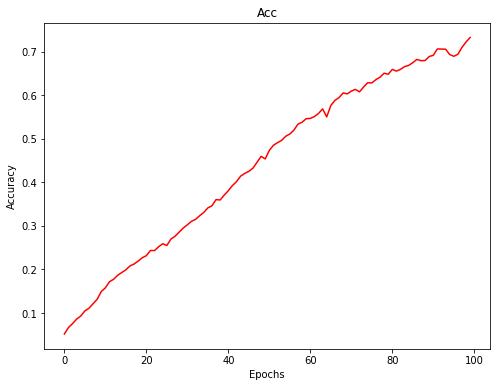

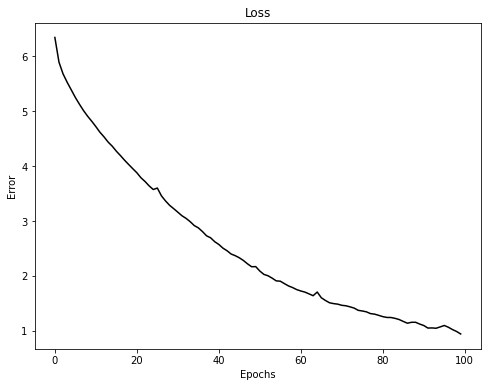

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot acc and Loss
#------------------------------------------------
plt.figure(figsize=(8, 6));
plt.plot(epochs, acc, 'red', label='acc')
plt.title('Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show();
plt.figure(figsize=(8, 6));
plt.title('Loss')
plt.plot(epochs, loss, 'black', label='loss')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show();

In [ ]:
def generate_text(seed_text, next_words, model_trained, tokenizer, n_words_max):
  for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=n_words_max-1, padding='pre')
    predicted = model_trained.predict_classes(token_list, verbose=0)[0]
    output_word = tokenizer.index_word[predicted]
    seed_text += " " + output_word
  return seed_text    

In [ ]:
seed_text = "Las imágenes de una pesadilla"
next_words = 100
generated_text = generate_text(seed_text, next_words, model_trained, tokenizer, n_words_max)
print(generated_text)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Las imágenes de una pesadilla persona que si era posible que se me abría mientras yo hay casualidades . encontrarla en absoluto , no tienen detenerme , durante esos meses de emplear el análisis más superficial revela innecesarias . maté en su agitado , en su club ? se me nervioso el 1 ( absurdo , al otro martín por ese caso , cualidades ciertos vuelto a la puerta de la compañía t . el encandilamiento algo que sugería edad , algo típico de una mujer que jamás ha notado que la sociedad estratos hubo muy improbable que las esperar y mientras se sonroja ;


In [ ]:
seed_text = "intuí que una gran fuerza"
next_words = 100
generated_text = generate_text(seed_text, next_words, model_trained, tokenizer, n_words_max)
print(generated_text)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


intuí que una gran fuerza , hasta qué miró todavía lo meses de atolondramiento y de una casualidad , estaba bien arquitecturado . encontrarla en absoluto no no abrir la boca y como un cuadro llamado maternidad . mató a esos escritorio , buscó en el estilo de pronto se me abría 1 una oscura pero vasta y poderosa perspectiva ; intuí que una gran fuerza , hasta ese momento dormida , se desencadenaría en esos instantes , otra pregunta artificioso como más ajeno a la puerta del edificio y del club del tipo de la esquina , desde cuya vereda podía vigilar la la


## LSTM

In [ ]:
def create_model(params):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Embedding(params.len_vocab, params.embedding_dim, input_length=params.max_sequence_len-1))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=params.rnn_units,
                                                          return_sequences=True,
                                                          activation=params.hidden_activation,
                                                          name='bilstm_layer1')))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=params.rnn_units,
                                                          return_sequences=False,
                                                          activation=params.hidden_activation,
                                                          name='bilstm_layer2')))
  model.add(tf.keras.layers.Dense(units=params.dense_units, 
                                   activation=params.dense_activation,
                                   name='dense1') )
  model.add(tf.keras.layers.Dense(units = params.len_vocab,
                                  activation='softmax',
                                  name='ouput_layer'))
  model.summary()
  return model

def train(params, model, X, y):
    # Compile the model
    model.compile(loss=params.loss,
                  metrics=params.metrics,
                  optimizer=params.optimizer)  
    
    # fit
    history = model.fit(X,
                        y,
                        epochs=params.epochs,
                        verbose=params.verbose,
                        callbacks=params.callbacks)

    return model, history  

Args = namedtuple('Args', 
                  ['len_vocab', 'embedding_dim', 'max_sequence_len', 'rnn_units', 'hidden_activation', 
                   'dense_units', 'dense_activation', 'loss' ,'metrics', 'optimizer', 'epochs', 'verbose', 'callbacks'])
params = Args(len_vocab=len(tokenizer.word_index), 
              embedding_dim=300,
              max_sequence_len=n_words_max,
              rnn_units=256,
              hidden_activation='tanh',
              dense_units=256,
              dense_activation='relu',
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam',
              epochs=100,
              verbose=1,
              callbacks=[])


tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model_created = create_model(params)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 300)          610200    
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 512)          1140736   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dense1 (Dense)               (None, 256)               131328    
_________________________________________________________________
ouput_layer (Dense)          (None, 2034)              522738    
Total params: 3,979,914
Trainable params: 3,979,914
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_trained, history = train(params, model_created, n_grams_history, labels)

Epoch 1/100
248/248 [==============================] - 46s 139ms/step - loss: 6.5569 - accuracy: 0.0481
Epoch 2/100
248/248 [==============================] - 34s 138ms/step - loss: 5.7495 - accuracy: 0.0640
Epoch 3/100
248/248 [==============================] - 34s 138ms/step - loss: 5.4970 - accuracy: 0.0766
Epoch 4/100
248/248 [==============================] - 34s 138ms/step - loss: 5.3318 - accuracy: 0.0796
Epoch 5/100
248/248 [==============================] - 34s 138ms/step - loss: 5.1743 - accuracy: 0.0898
Epoch 6/100
248/248 [==============================] - 34s 138ms/step - loss: 4.9773 - accuracy: 0.1158
Epoch 7/100
248/248 [==============================] - 34s 139ms/step - loss: 4.8772 - accuracy: 0.1246
Epoch 8/100
248/248 [==============================] - 34s 138ms/step - loss: 4.7017 - accuracy: 0.1422
Epoch 9/100
248/248 [==============================] - 34s 137ms/step - loss: 4.5798 - accuracy: 0.1539
Epoch 10/100
248/248 [==============================] - 34s 137m

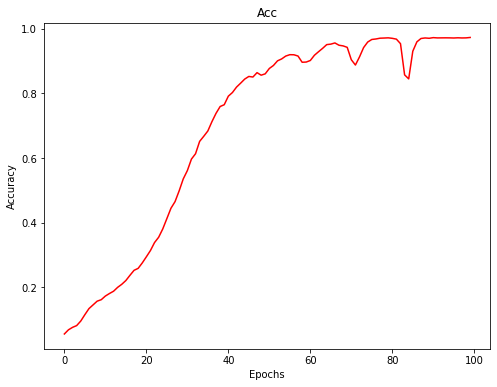

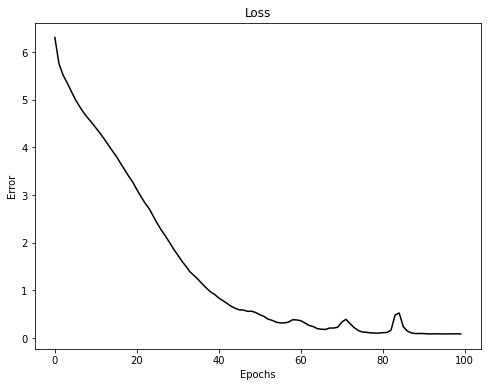

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot acc and Loss
#------------------------------------------------
plt.figure(figsize=(8, 6));
plt.plot(epochs, acc, 'red', label='acc')
plt.title('Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show();
plt.figure(figsize=(8, 6));
plt.title('Loss')
plt.plot(epochs, loss, 'black', label='loss')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show();

In [ ]:
seed_text = "Las imágenes de una pesadilla"
next_words = 100
generated_text = generate_text(seed_text, next_words, model_trained, tokenizer, n_words_max)
print(generated_text)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Las imágenes de una pesadilla mujer que miraba como esperando algo , quizá algún llamado apagado y distante . vuelta hasta la ventana empezara a crecer y a invadir toda la tela y toda mi obra . alejado de las preocupaciones diarias como la esencia general del arte o , por lo menos , la impresión que le había producido mi ventanita . , en ese momento me llenaba de vergüenza y me hacía sentir aun más ridículo : ¿le gusta castel ? '' . pero no sé si ya dije que voy a relatar mi crimen ) y , sobre todo , a buscar


In [ ]:
seed_text = "intuí que una gran fuerza"
next_words = 100
generated_text = generate_text(seed_text, next_words, model_trained, tokenizer, n_words_max)
print(generated_text)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


intuí que una gran fuerza , hasta ese momento de semejante idea . , sólo dejar de mirar el trabajo , pues lo hacía pasar inadvertido . , es cierto , la única pregunta . mientras el tiempo o pero por el estilo ; respuesta : es una dirección . en general y decidido a el asunto de la rata . , fija , crean que es una mera manía , cuando en verdad obedece a razones muy profundas . preguntas : —¿a dónde ? —le pregunté . estaba parecido admirables aparecían acentuados y deformados en la hermana , un poco caricaturizados . miré el


## GRU

In [ ]:
def create_model(params):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Embedding(params.len_vocab, params.embedding_dim, input_length=params.max_sequence_len-1))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=params.rnn_units,
                                                          return_sequences=True,
                                                          activation=params.hidden_activation,
                                                          name='bilstm_layer1')))
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=params.rnn_units,
                                                          return_sequences=False,
                                                          activation=params.hidden_activation,
                                                          name='bilstm_layer2')))
  model.add(tf.keras.layers.Dense(units=params.dense_units, 
                                   activation=params.dense_activation,
                                   name='dense1') )
  model.add(tf.keras.layers.Dense(units = params.len_vocab,
                                  activation='softmax',
                                  name='ouput_layer'))
  model.summary()
  return model

def train(params, model, X, y):
    # Compile the model
    model.compile(loss=params.loss,
                  metrics=params.metrics,
                  optimizer=params.optimizer)  
    
    # fit
    history = model.fit(X,
                        y,
                        epochs=params.epochs,
                        verbose=params.verbose,
                        callbacks=params.callbacks)

    return model, history  

Args = namedtuple('Args', 
                  ['len_vocab', 'embedding_dim', 'max_sequence_len', 'rnn_units', 'hidden_activation', 
                   'dense_units', 'dense_activation', 'loss' ,'metrics', 'optimizer', 'epochs', 'verbose', 'callbacks'])
params = Args(len_vocab=len(tokenizer.word_index), 
              embedding_dim=300,
              max_sequence_len=n_words_max,
              rnn_units=256,
              hidden_activation='tanh',
              dense_units=256,
              dense_activation='relu',
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam',
              epochs=100,
              verbose=1,
              callbacks=[])


tf.keras.backend.clear_session()


model_created = create_model(params)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 300)          610200    
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 512)          857088    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1182720   
_________________________________________________________________
dense1 (Dense)               (None, 256)               131328    
_________________________________________________________________
ouput_layer (Dense)          (None, 2034)              522738    
Total params: 3,304,074
Trainable params: 3,304,074
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_trained, history = train(params, model_created, n_grams_history, labels)

Epoch 1/100
248/248 [==============================] - 36s 121ms/step - loss: 6.5618 - accuracy: 0.0493
Epoch 2/100
248/248 [==============================] - 30s 120ms/step - loss: 5.8041 - accuracy: 0.0686
Epoch 3/100
248/248 [==============================] - 30s 120ms/step - loss: 5.4988 - accuracy: 0.0885
Epoch 4/100
248/248 [==============================] - 30s 120ms/step - loss: 5.2322 - accuracy: 0.1025
Epoch 5/100
248/248 [==============================] - 30s 121ms/step - loss: 4.9677 - accuracy: 0.1378
Epoch 6/100
248/248 [==============================] - 30s 121ms/step - loss: 4.6298 - accuracy: 0.1707
Epoch 7/100
248/248 [==============================] - 30s 121ms/step - loss: 4.4153 - accuracy: 0.1992
Epoch 8/100
248/248 [==============================] - 30s 121ms/step - loss: 4.1219 - accuracy: 0.2205
Epoch 9/100
248/248 [==============================] - 30s 121ms/step - loss: 3.8852 - accuracy: 0.2545
Epoch 10/100
248/248 [==============================] - 30s 121m

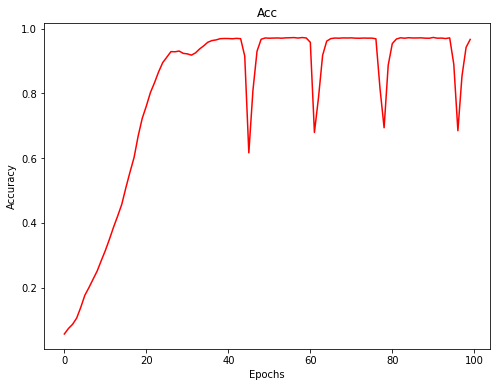

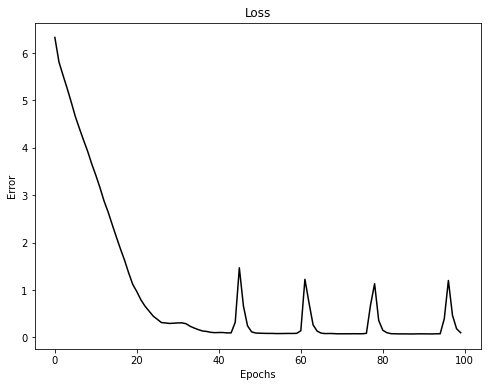

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot acc and Loss
#------------------------------------------------
plt.figure(figsize=(8, 6));
plt.plot(epochs, acc, 'red', label='acc')
plt.title('Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show();
plt.figure(figsize=(8, 6));
plt.title('Loss')
plt.plot(epochs, loss, 'black', label='loss')
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show();

In [ ]:
seed_text = "Las imágenes de una pesadilla"
next_words = 100
generated_text = generate_text(seed_text, next_words, model_trained, tokenizer, n_words_max)
print(generated_text)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Las imágenes de una pesadilla variante que jamás había pensado y 14 sin embargo muy lógica , pues mi fotografía había aparecido muchísimas veces en revistas y diarios . una asamblea de cien mil rusos , nadie me entendería . hasta el resto de mis semejantes . . en iniciar una aventura ? . era imaginario y que al menos seguía quedando la posibilidad real . . no hizo ningún comentario . no dar explicaciones que estaba aislada del mundo entero ; no vio ni oyó a la gente que pasaba o se detenía frente a mi tela . hasta el extremo , miré el


In [ ]:
seed_text = "intuí que una gran fuerza"
next_words = 100
generated_text = generate_text(seed_text, next_words, model_trained, tokenizer, n_words_max)
print(generated_text)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


intuí que una gran fuerza , pero sólo definitiva , lo que daba esa impresión de edad . la pregunta era imaginario y que al menos seguía quedando la posibilidad real . . no hizo ningún comentario . no dar explicaciones sobre la sociedad psicoanalítica ; el partido , por el partido comunista , la séptima , por la séptima sinfonía de beethoven . no decisión , por dos la hermana , felizmente , ¿comprende y ella ) no podía nervioso : eran lógicas o por lo menos posibles . . . hasta el árbol muy sutil , en la manera de vinculaciones y ,


Luego de analizar los resultados obtenidos por las tres redes propuestas, es notoria la mejora de la LSTM y la GRU con respecto a la RNN, esto debido a que esta última tiene memoria de muy corto plazo, por lo que las otras resultan mucho más eficientes para el tipo de ejercicio que se está abordando en el cual se busca crear sentido a oraciones e incluso párrafos enteros. Además, la red que creo las frases con más sentido fue la LSTM


<img src="https://gitlab.com/bivl2ab/academico/cursos-uis/cv/cv-uis-student/raw/master/imgs/bannerThanks.jpg" style="width:1000px;">